<p align="center">
  <img src="../img/churn3.png" title="mind_map">
</p>

# CONTEXTO DO PROBLEMA

A **TopBank** é uma grande empresa de serviços bancários. Ela atua principalmente nos países da Europa oferecendo produtos financeiros, desde contas bancárias até investimentos, passando por alguns tipos de seguros e produto de investimento.

O modelo de negócio da empresa é do tipo serviço, ou seja, ela comercializa serviços bancários para seus clientes através de agências físicas e um portal online. 

O principal produto da empresa é uma conta bancária, na qual o cliente pode depositar seu salário, fazer saques, depósitos e transferência para outras contas. Essa conta bancária não tem custo para o cliente e tem uma vigência de 12 meses, ou seja, o cliente precisa renovar o contrato dessa conta para continuar utilizando pelos próximos 12 meses.

Segundo o time de Analytics da TopBank, cada cliente que possui essa conta bancária retorna um valor monetário de 15% do valor do seu salário estimado, se esse for menor que a média e 20% se esse salário for maior que a média, durante o período vigente de sua conta. Esse valor é calculado anualmente. 

Por exemplo, se o salário mensal de um cliente é de 1.000,00 reais e a média de todos os salários do banco é de 800,00 reais A empresa, portanto, fatura 200,00 reais anualmente com esse cliente. Se esse cliente está no banco a 10 anos, a empresa já faturou 2.000,00 reais com suas transações e utilização da conta. 

Nos últimos meses, o time de Analytics percebeu que a taxa de clientes cancelando suas contas e deixando o banco, atingiu números inéditos na empresa. Preocupados com o aumento dessa taxa, o time planejou um plano de ação para diminuir taxa de evasão de clientes.

Preocupados com a queda dessa métrica, o time de Analytics da TopBottom, contratou você como consultor de Data Science para criar um plano de ação, com o objetivo de reduzir a evasão de clientes, ou seja, impedir que o cliente cancele seu contrato e não o renove por mais 12 meses. Essa evasão, nas métricas de negócio, é conhecida como Churn.

De maneira geral, Churn é uma métrica que indica o número de clientes que cancelaram o contrato ou pararam de comprar seu produto em um determinado período de tempo. Por exemplo, clientes que cancelaram o contrato de serviço ou após o vencimento do mesmo, não renovaram, são clientes considerados em churn.

Outro exemplo seria os clientes que não fazem uma compra à mais de 60 dias. Esse clientes podem ser considerados clientes em churn até que uma compra seja realizada. O período de 60 dias é totalmente arbitrário e varia entre empresas. 

# O PROBLEMA

Como um Consultor de Ciência de Dados, você precisa criar um plano de ação para diminuir o número de clientes em churn e mostrar o retorno financeiro da sua solução.

Ao final da sua consultoria, você precisa entregar ao CEO da TopBottom um modelo em produção, que receberá uma base de clientes via API e retornará essa mesma base “scorada”, ou seja, um coluna à mais com a probabilidade de cada cliente entrar em churn.

Além disso, você precisará fornecer um relatório reportando a performance do seu modelo e o impacto financeiro da sua solução. Questões que o CEO e o time de Analytics gostariam de ver em seu relatório:

- Qual a taxa atual de Churn da TopBank? 
- Qual a Performance do modelo em classificar os clientes como churns?
- Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?

Uma possível ação para evitar que o cliente entre em churn é oferecer um cupom de desconto, ou alguma outro incentivo financeiro para ele renovar seu contrato por mais 12 meses.

- Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$50.000,00

# ENTENDIMENTO DO PROBLEMA

**Motivação:** Diminuir a taxa de Churn da empresa.

**Causa Raiz do Problema:** Estimular a compra de clientes em Churn.

**Tipo de Problema:** Classificar a propensão dos clientes entrarem em Churn.

**Potênciais Métodos:** Classificação, Rank to Learn.

**Granularidade:** Previsão de Churn por cliente.

**Entraga da Solução:** WebApp Streamlit

**Dados para Resolver o Problema**: [Kaggle](https://www.kaggle.com/mervetorkan/churndataset)

# 0.0 IMPORTS

In [4]:
# manipulation
import pandas as pd
import inflection

# math and statistic
import numpy as np
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scikitplot.metrics import plot_roc

# preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from boruta import BorutaPy

# model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

# metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from scikitplot import metrics
from sklearn.metrics import confusion_matrix

# deploy
import pickle
import json
import requests

# others
import warnings
from typing    import Iterable, Any
from itertools import product

## 0.1 Funções Auxiliares

In [96]:
# color style
palette = ['#5e9fa3', '#dcd1b4', '#fab87f', '#f87e7b', '#b05574']

def plot_box(x1, x2, x3, df, color):
    
    '''
    função para criar 3 boxplots na mesma linha.
    
    paremtros: x1 -> variavel/coluna 1º posição: series pandas
               x2 -> variavel/coluna 2º poisção: series pandas
               x3 -> variavel/coluna 3º posição: series pandas
               df -> dataset: dataframe pandas
               
    retorno: sem retorno.
    '''
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    sns.boxplot(x=x1, data=df, color=color)
    sns.despine(right=True)
    
    plt.subplot(2, 3, 2)
    sns.boxplot(x=x2, data=df, color=color)
    sns.despine(right=True)
    
    plt.subplot(2, 3, 3)
    sns.boxplot(x=x3, data=df, color=color)
    sns.despine(right=True)



def plot_bar(x1, x2, x3, df, palette):
    
    '''
    função para criar 3 gráficos de barras na vertical na mesma linha.
    
    paremtros: x1 -> variavel/coluna 1º posição: series pandas
               x2 -> variavel/coluna 2º poisção: series pandas
               x3 -> variavel/coluna 3º posição: series pandas
               df -> dataset: dataframe pandas
               
    retorno: sem retorno.
    '''
    
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    sns.countplot(x=x1, data=df, palette=palette)
    sns.despine(right=True)

    plt.subplot(1, 3, 2)
    sns.countplot(x=x2, data=df, palette=palette)
    sns.despine(right=True)
    
    plt.subplot(1, 3, 3)
    sns.countplot(x=x3, data=df, palette=palette)
    sns.despine(right=True)
    
    
# correlation categories
def cramer_v(x, y):
    
    '''
    função para calcular correlações de variaveis
    categóricas usando o metodo de cramer v
    
    pametros: x -> coluna 1: series pandas
              y -> coluna 2: series pandas
              
    retorna o valor da correlação entre a coluna 1 e 2.
    '''
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) **2 / (n-1)
    rcorr = r - (r-1) **2 / (n-1)
    
    return np.sqrt((chi2_corr / n) / (min(kcorr-1, rcorr-1)))


# Show matrix correlation
def show_matrix(col, data, output='list'):
    
    '''
    função para aplicar o cramer v em cada feature de um dataframe.
    
    paremtros: col    -> a primeira feature categórica do dataframe: str
               data   -> dataset: dataframe pandas
               output -> list = armazena as correlações em uma lista,
                         dict = armazena as correlações em um dicionario: str
                         
    retorno: retorna os resultados entre as correlações de um datframe.
    '''

    rows = []
    index = []
    columns = []

    for c in data.columns:

        result = cramer_v(x=data[str(col)], y=data[str(c)])

        rows.append(result)
        index.append(str(c))
        columns.append(str(col))
        
    if output == 'list':
        return rows
    
    elif output == 'dict':
        return pd.DataFrame(rows, index=index, columns=[str(col)])

    
def plot_curve(model_name, y_pred, y_true):
    
    '''
    função para plotar curvas lift e ganho acumulativo.
    
    paremtros: model_name -> nome do modelo usado: str
               y_pred     -> predições do modelo:  array numpy
               y_true     -> valores reais:        array numpy
               
    retorno: sem retorno.
    '''
    
    n_customers = 2000 # numero de clientes total da base
    n_customer_target = k # numero de clientes a serem ranqueados
    qty = n_customer_target / n_customers # calculando % dos clientes alvos na amostra total
    
    # Cumulative Gains Curve
    title1, title2 = 'Cumulative Gains Curve', 'Lift Curve'
    metrics.plot_cumulative_gain(y_true, y_pred, figsize=(15, 5), title=title1+' - ' + model_name)
    plt.axvline(qty, color='r', linestyle='dashed', label='k={}'.format(k)) # criando uma linha vertical com % de clientes
    plt.legend()
    
    # lift curve
    metrics.plot_lift_curve(y_true, y_pred, figsize=(15, 5), title=title2+' - ' + model_name)
    plt.axvline(qty, color='r', linestyle='dashed', label='k={}'.format(k)) # criando uma linha vertical com % de clientes
    plt.legend();
    
    
def precision_at_k(x_test, y_test, yhat, k):
    
    '''
    função para calcular a métrica precision@k.
    
    
    paremtros: x_test -> dados com as features de teste: array/dataframe
               y_test -> dados com o target de teste     array
               yhat   -> predições do modelo             array
               k      -> numero de top K                 int
               
    retorno: retorna o valor da precição em top K.
    '''
    
    # Add prob in the data to cumpute metric
    data_metric = x_test.copy()
    data_metric['response'] = y_test

    # Propensity score
    data_metric['score'] = list(yhat[:, 1])

    # Sort clients by propensity score
    data_metric = data_metric.sort_values(by='score', ascending=False)
    
    # Sort clients by propensity score
    data_metric = data_metric.sort_values(by='score', ascending=False)

    # Reset index
    data_metric = data_metric.reset_index(drop=True)

    # Create ranking order
    data_metric['ranking'] = data_metric.index + 1

    # Calculate precision in K
    data_metric['precision_at_k'] = data_metric['response'].cumsum() / data_metric['ranking']
    
    return data_metric.loc[k, 'precision_at_k'] # Return result precision


def recall_at_k(x_test, y_test, yhat, k):
    
    '''
    função para calcular a métrica recall@k.
    
    
    paremtros: x_test -> dados com as features de teste: array/dataframe
               y_test -> dados com o target de teste     array
               yhat   -> predições do modelo             array
               k      -> numero de top K                 int
               
    retorno: retorna o valor de recall em top K.
    '''
    
    # Add prob in the data to cumpute metric
    data_metric = x_test.copy()
    data_metric['response'] = y_test

    # Propensity score
    data_metric['score'] = list(yhat[:, 1])
    
    # Sort clients by propensity score
    data_metric = data_metric.sort_values(by='score', ascending=False)

    # Reset index
    data_metric = data_metric.reset_index(drop=True)

    # Create ranking order
    data_metric['ranking'] = data_metric.index + 1

    # Calculate recall in K
    data_metric['recall_at_k']= data_metric['response'].cumsum() / data_metric['response'].sum()
    
    return data_metric.loc[k, 'recall_at_k'] # Return result recall at k


def cross_validation(model_name, x, y, model, cv, k, verbose=True):
    
    '''
    função para realizar validação cruzada com
    as métrcias precision@k e recall@k.
    
    parametros: model_name -> nome do modelo treinado: str
                x          -> features: dataframe pandas|numpy array
                y          -> target  : numpy array
                model      -> modelo intanciado: object
                cv         -> numero de folds de cv: int
                k          -> numero de top K
                verbose    -> True  = mostra os logs enquanto execulta,
                              False = não mostra: bool
                
    retorno: retorna um dataframe contendo os resultados das métricas
    
    '''
    
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    precision = []
    recall = []
    fold = 0
    
    for train, test in kfold.split(x, y):
        fold += 1
        
        if verbose:
            print(f'Number KFold: {fold}/{cv}')
        
        # trainigng
        x_train = x.iloc[train].copy()
        y_train = y.iloc[train].copy()  
        
        # validation
        x_val = x.iloc[test].copy() 
        y_val = y.iloc[test].copy() 
        
        # Model training
        model_trained = model.fit(x_train, y_train)
        yhat_model = model_trained.predict_proba(x_val)

        # -- Performance
        x_val['response'] = y_val.copy() # Add target in the data to cumpute metric

        # Propensity score
        x_val['score'] = list(yhat_model[:, 1])

        # Sort clients by propensity score
        df = x_val.sort_values(by='score', ascending=False)

        # Compute precision at K
        precision.append(precision_at_k(x_test=x_val, y_test=y_val, yhat=yhat_model, k=k))
        recall.append(recall_at_k(x_test=x_val, y_test=y_val, yhat=yhat_model, k=k))
        
    model_metric = pd.DataFrame({
            'model_name': model_name,
            'number of K': k,
            'precision_top_at': np.mean(precision),
            'recall_top_at': np.mean(recall),
            }, index=[0])
    
    return model_metric


def grid_parameters(parameters: dict[str, Iterable[Any]]) -> Iterable[dict[str, Any]]:
    
    '''
    A função recebe o conjunto de parametros e itera
    entre as possibilidades de junções de cada um.
    
    paremtros: lista de paremtros para iterar: dict
    retorno: sem retorno
    '''
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))
        
        
        
def grid_search(min_child_weight, n_estimators, model, max_depth, model_name):
    
    '''
    função para aplicar grid search em 3 modelos.
    
    paremtros: min_child_weight -> parametros para teste: list
               n_estimators     -> parametros para teste: list
               max_depth        -> parametros para teste: list
               model            -> modelo instanciado: object
               model_name       -> nomo do modelo treinado: str
               
    retorno: retorna um dicionario com os resultados das métricas
             precision@k e recall@k
    '''
    
    parameters = {
        'min_child_weight': min_child_weight,
        'n_estimators': n_estimators, 
        'max_depth': max_depth
    }
    
    k = 200
    cv = 5
    final_result, min_child_weight, n_estimators, max_depth = pd.DataFrame(), list(), list(), list()
    for settings in grid_parameters(parameters):

        param = {
            'min_child_weight': settings['min_child_weight'], 'n_estimators': settings['n_estimators'], 'max_depth': settings['max_depth']
        }
        
        if model == 'xgboost':
            # define xgboost
            model_tunning = xgb.XGBClassifier(
                                    min_child_weight=param['min_child_weight'],
                                    n_estimators=param['n_estimators'],
                                    max_depth=param['max_depth']
                                )
        elif model == 'forest':
            # define random forest
            model_tunning = RandomForestClassifier(
                                    min_samples_split=param['min_child_weight'],
                                    n_estimators=param['n_estimators'],
                                    max_depth=param['max_depth']
                                )
        elif model == 'lgbm':
            # define lgbm
            model_tunning = LGBMClassifier(
                                min_child_weight=param['min_child_weight'],
                                n_estimators=param['n_estimators'],
                                max_depth=param['max_depth']
                            )
        # performance
        result = cross_validation(model_name=model_name, model=model_tunning, x=x_full, y=y_full, cv=cv, k=k, verbose=False)
        final_result = pd.concat([final_result, result])
        
        # add parameters in list
        min_child_weight.append(param['min_child_weight'])
        n_estimators.append(param['n_estimators'])
        max_depth.append(param['max_depth'])

    # add parameter into df
    final_result['min_child_weight'] = min_child_weight
    final_result['n_estimators'] = n_estimators
    final_result['max_depth'] = max_depth
    final_result['cross_validation'] = cv
    
    return final_result.sort_values(by='recall_top_at', ascending=False).head()

## 0.2 Carregamento de Dados

In [136]:
# loading data
df = pd.read_csv('../data/Churn.csv')

# show data
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [137]:
df1 = df.copy() # copy data to section 1

print('Nº Rows:', df1.shape[0]) # show quantity rows
print('Nº Cols:', df1.shape[1]) # show quantity columns 

Nº Rows: 10000
Nº Cols: 14


## 1.2 Renomeação de Colunas

In [138]:
# Columns to snakecase
snakecase = lambda x: inflection.underscore(x)

# New columns with snakecase
new_columns = (map(snakecase, df1.columns))
df1.columns = new_columns

# show new columns
df1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Tipo de Dados

In [139]:
# show data type
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Verificação de Dados Faltantes

In [140]:
# show data NaN
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Estatistica Descritiva

### 1.5.1 Variavel Numérica

In [141]:
# show data description 
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
row_number,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
num_of_products,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
has_cr_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
is_active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


**Insight:**

- <ins>credit_score</ins>: Em média, o score de crédito dos clientes é de 650, o menor é 350 e o maior é 850.

- <ins>age</ins>: Em média, os clientes possuem 38 anos de idade, o cliente mais novo tem 18 anos e o mais velho tem 92 anos.

- <ins>tenure</ins>: Em média, os clientes permanecem 5 anos ativos, há clientes que ficam menos de um ano ativos e que ficam 10 anos.

- <ins>num_of_products</ins>: Em média, os clientes compraram cerca de 1 produto do banco, o mínimo de produtos adquiridos é 1 e o máximo é 4 produtos.

- <ins>has_cr_card</ins>: 75% dos clientes possuem cartão de crédito.

- <ins>is_active_member</ins>: 75% dos clientes são menbros ativos.

- <ins>exited:</ins> 75% dos clientes não sairam do banco.

### 1.5.2 Variavel Categórica

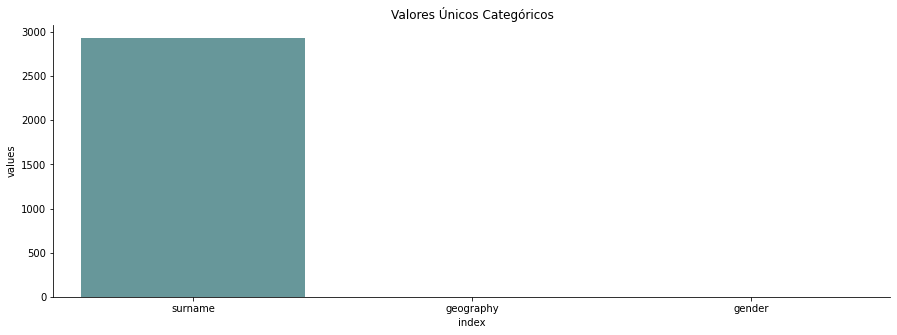

In [142]:
categorical = df1.select_dtypes(include=['object']) # filter categorical
qty_values = categorical.apply(lambda x: len(x.unique())).reset_index().rename(columns={0: 'values'}) # count unique values

# Create figure
plt.figure(figsize=(15, 5))
sns.barplot(x='index', y='values', data=qty_values, color=palette[0])
plt.title('Valores Únicos Categóricos')
sns.despine(right=True);

**Insight:**

No geral, as variaveis categóricas não posuem um grande range de possíveis valores, com exceção de Surname que contém cerca de 3 mil.

# 2.0 FEATURE ENGINEERING

## 2.1 Mapa Mental de Hipóteses

<p align="center">
  <img src="../img/mind_map_cycle2.png" width="1000" title="mind_map">
</p>

## 2.2 Hipóteses

### 2.2.1 Hipóteses Clientes

**1.** Clientes com menor Score, entram mais em Churn.

**2.** Clientes localizados na Alemanha, entram mais Churn.

**3.** Clientes do sexo Masculino, dão mais Churn.

**4.** Clientes acima de 40 anos, dão mais Churn.

**5.** Clientes com Salarios menor que a mediana, entram mais em Churn.

**6.** Clientes com poder aquisitivo baixo, entram mais em Churn.

### 2.2.2 Hipóteses Atividade

**1.** Clientes que não fizeram movimentações nos ultimos 12 meses, entram mais em Churn.

**2.** Clientes que compraram menos de 2 produtos, entram mais em Churn. 

**3.** Clientes que permaneceram ativos por menos de 3 anos, entram mais em Churn.

**4.** Clientes que ficam com a conta zerada, entram mais em Churn.

**5.** Clientes que possuem valor menor que a mediana na conta, entram mais em Churn.

**6.** Clientes que não possuem cartão de crédito, entram mais em Churn.

**7.** Clientes que trazem maior retorno, entram mais em Churn.

## 2.3 Feature Engineering 

In [143]:
df2 = df1.copy() # copy data to section 2

# create feature credit_score_category
df2['credit_score_category']= df2['credit_score'].apply(lambda x: 'ruim' if x > 300 and x <= 500 else 'regular'
                                                                         if x > 500 and x <= 700 else 'bom')
# create feature category_age
df2['category_age'] = df2['age'].apply(lambda x: '>= 40' if x > 40 else '< 40')

# create feature category_salary
MEDIAN_SALARY = df2['estimated_salary'].median()
df2['category_salary'] = df2['estimated_salary'].apply(lambda x: 'higher salary' if x > MEDIAN_SALARY else 'lower salary')

# create feature num_of_products_category
df2['num_of_products_category'] = df2['num_of_products'].apply(lambda x: '< 2' if x < 2 else '>= 2')

# create feature tenure_category
df2['tenure_category'] = df2['tenure'].apply(lambda x: '< 3' if x < 3 else '>= 3')

# create feature balance_zero
df2['balance_zero'] = df2['balance'].apply(lambda x: 'zero' if x == 0.0 else 'not zero')

# create feature category_balance
MEDIAN_BALANCE = df2['balance'].median()
df2['category_balance'] = df2['balance'].apply(lambda x: 'higher balance' if x > MEDIAN_BALANCE else 'lower balance')

# create feature purchasing_power
df2['purchasing_power'] = df2['estimated_salary'].apply(lambda x: 'low' if x < 3000 else 'regular'
                                                                        if x >= 3000 and x < 8000 else 'high')
# create feature customer_return
avg_salary = df2['estimated_salary'].mean()
df2['customer_return'] = df2[['estimated_salary', 'tenure']].apply(lambda x: (x['estimated_salary'] * 20) / 100 * x['tenure'] if x['estimated_salary'] > avg_salary else (x['estimated_salary'] * 15) / 100 * x['tenure'], axis=1)

# 3.0 FILTRAGEM DE DADOS

## 3.1 Filtragem de Colunas

In [144]:
# drop columns not used
df2.drop(columns=['row_number', 'surname'], inplace=True)

# 4.0 EDA

## 4.1 Análise Univariada

### 4.1.1 Variavel Target

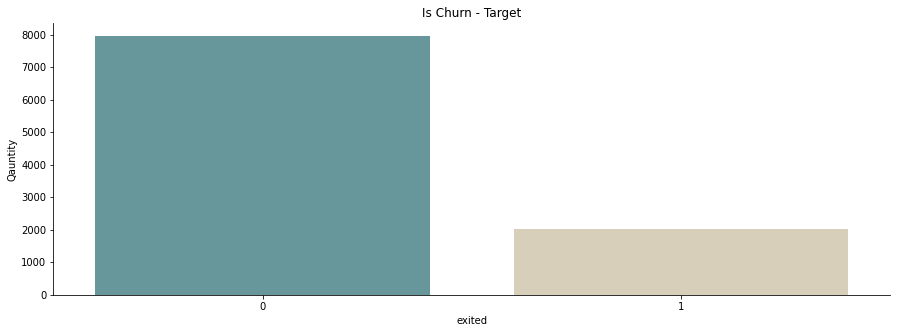

In [145]:
df4 = df2.copy() # copy data to section 4

# figure with target distribuition 
plt.figure(figsize=(15, 5))
sns.countplot(x='exited', data=df4, palette=palette)
plt.title('Is Churn - Target')
plt.ylabel('Qauntity')
sns.despine(right=True)

**Insight:**

Quase 8 mil (80%) de clientes não são Churns e cerca de 2 mil (20%) são Churns.

### 4.1.2 Variavel Numérica

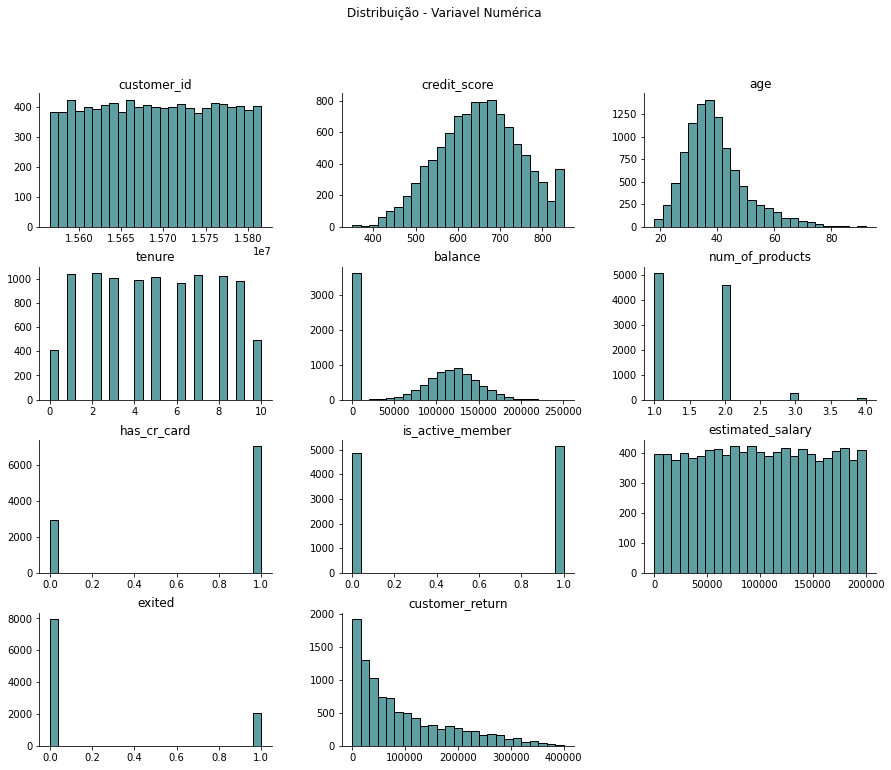

In [146]:
# filter numerical attributes
num = df4.select_dtypes(include=['int64', 'float64'])

# create histogram
num.hist(figsize=(15, 12), grid=False, bins=25, ec='k', color=palette[0])
plt.suptitle('Distribuição - Variavel Numérica')
sns.despine(right=True);

**Insight:**

- <ins>credit_score</ins>: há maior quantidade de score entre 600 e 700.

- <ins>age</ins>: há maior quantidade de clientes com idade entre 30 e 45 anos.

- <ins>num_of_products</ins>: há maior quantidade de clientes que compraram entre 1 e 2 produtos do banco.

- <ins>has_cr_card</ins>: há maior quantidade de clientes que possuem cartão de crédito.

- <ins>is_active_member</ins>: há quase que a mesma proporção de clientes que são ativos e aqueles que não são.

#### 4.1.21 Outliers

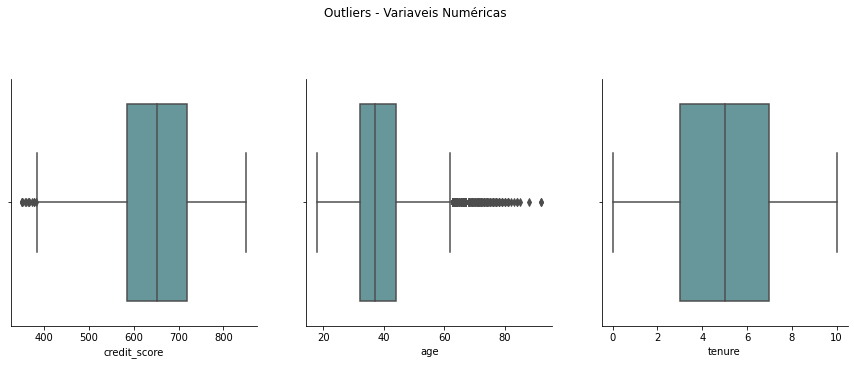

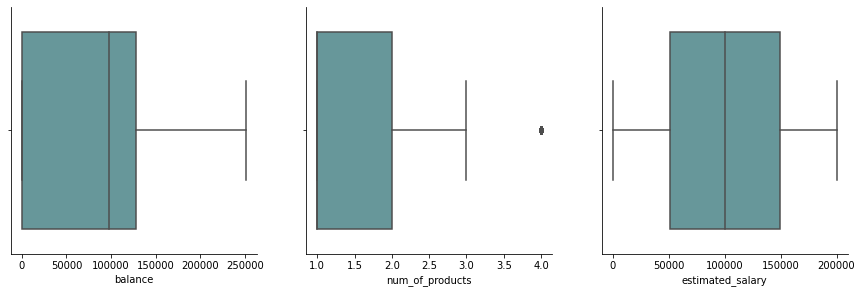

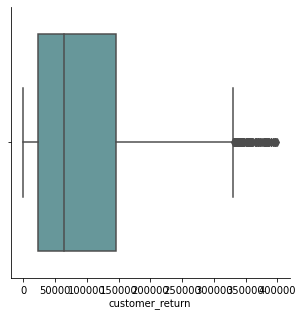

In [147]:
# apply function to create boxplot

# first line
plot_box(x1='credit_score', x2='age', x3='tenure', df=num, color=palette[0])
plt.suptitle('Outliers - Variaveis Numéricas')

# second line
plot_box(x1='balance', x2='num_of_products', x3='estimated_salary', df=num, color=palette[0])

# last line
plt.figure(figsize=(5, 5))
sns.boxplot(x='customer_return', data=num, color=palette[0])
sns.despine(right=True);

**Insight:**

Há 4 variaveis que possuem Outliers (valores extremos):

- <ins>credit_score</ins>: há poucos outliers inferiores em valores abaixo de 400.

- <ins>age</ins>: há muitos outliers superiores em valores de idade acima de 65 anos.

- <ins>num_of_products</ins>: há 1 outlier superior em valores de produtos comprados igual a 4.

- <ins>customer_return</ins>: há muitos outliers superiores em valores de retorno/lucro ao banco.

### 4.1.3 Variavel Categórica

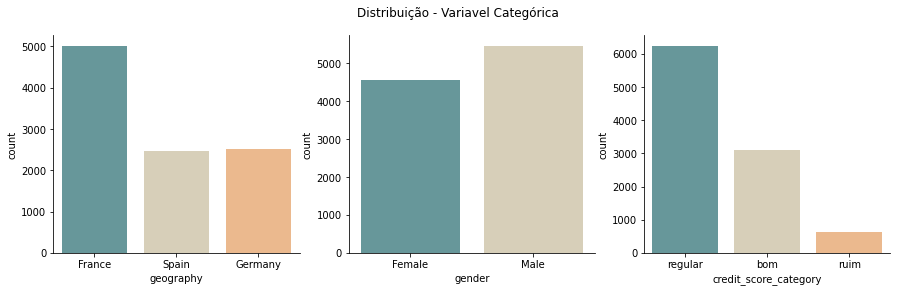

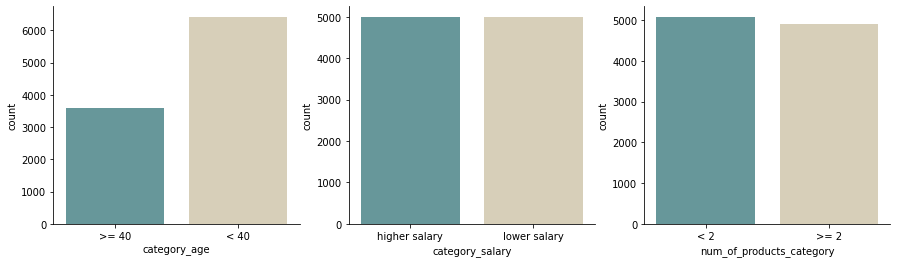

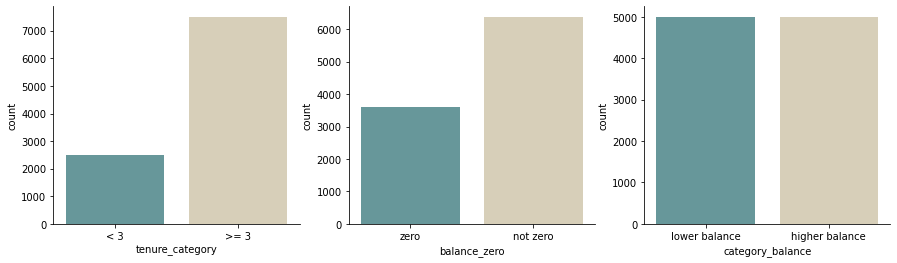

In [148]:
# filter categorical attributes
cat = df4.select_dtypes(include=['object'])

# apply function to plot:
# first line
plot_bar(x1='geography', x2='gender', x3='credit_score_category', df=cat, palette=palette)
plt.suptitle('Distribuição - Variavel Categórica');

# second line
plot_bar(x1='category_age', x2='category_salary', x3='num_of_products_category', df=cat, palette=palette)

# last line
plot_bar(x1='tenure_category', x2='balance_zero', x3='category_balance', df=cat, palette=palette)

**Insight:**

- <ins>geography</ins>: Há maior quantidade de clientes da França.

- <ins>age</ins>: Há maior quantidade de clienets do sexo masculino.

- </ins>credit_score_category</ins>: Há maior quantidade de clientes com score de crédito "regular".

- <ins>category_age</ins>: Há maior quantidade de clientes com idade menor que 40 anos.

- <ins>tenure_category</ins>: Há maior quantidade de clientes com 3 ou mais anos de atividade.

- </ins>balance_zero</ins>: Há maior quantidade de clientes que não possuem saldo zerado na conta.

## 4.2 Análise Bivariada

### **H1.** Clientes com Score ruim/menor, entram mais em Churn.

**FALSA** Clientes com Score <ins>Regular</ins>, entram mais em Churn.

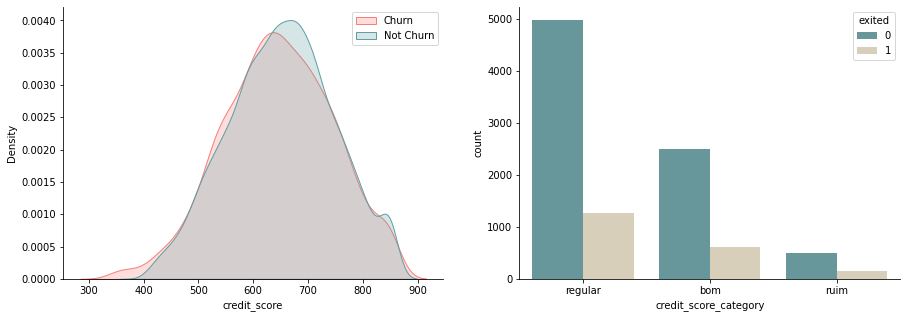

In [149]:
# fist figure 
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(x=df4[df4['exited'] == 1]['credit_score'], label='Churn', shade=True, color=palette[3])
sns.kdeplot(x=df4[df4['exited'] == 0]['credit_score'], label='Not Churn', shade=True, color=palette[0])
sns.despine(right=True) 
plt.legend() 

# second figure
plt.subplot(1, 2, 2)
sns.countplot(x='credit_score_category', hue='exited', data=df4, palette=palette)
sns.despine(right=True);

### **H2.** Clientes localizados na Alemanha, entram mais em Churn.

**VERDADEIRA** Clientes localizados na <ins>Alemanha</ins>, entram mais em Churn.

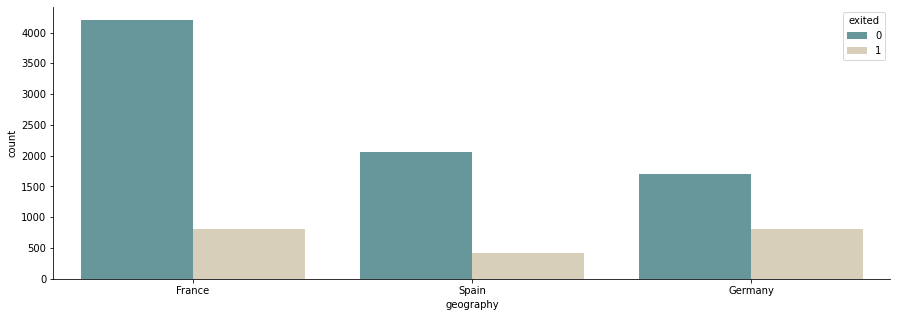

In [150]:
# create figure
plt.figure(figsize=(15, 5))
sns.countplot(x='geography', hue='exited', data=df4, palette=palette)
sns.despine(right=True)

### **H3.** Clientes do sexo Masculino, entram mais em Churn.

**FALSA** Clientes do sexo <ins>Feminino</ins>, entram mais em Churn

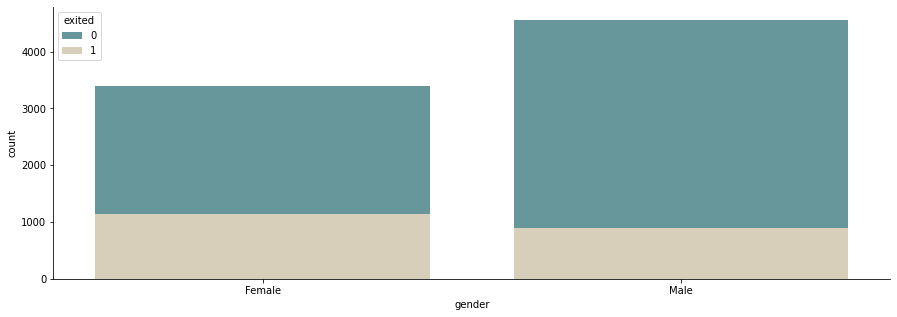

In [151]:
# figure
plt.figure(figsize=(15, 5))
sns.countplot(x='gender', data=df4, hue='exited', dodge=False, palette=palette)
sns.despine(right=True)

### **H4.** Clientes acima de 40 anos, entram mais em Churn.

**VERDADEIRA** Clientes <ins>acima</ins> de 40 anos, entram mais em Churn.

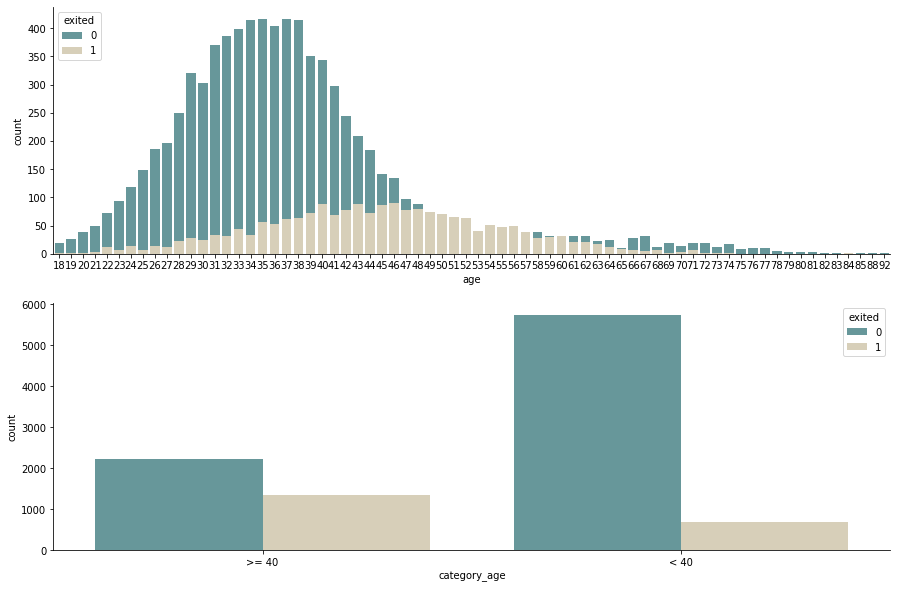

In [152]:
# first figure
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
sns.countplot(x='age', data=df4, hue='exited', dodge=False, palette=palette)
sns.despine(right=True)

# second figure
plt.subplot(2, 1, 2)
sns.countplot(x='category_age', data=df4, hue='exited', palette=palette)
sns.despine(right=True);

### **H**5. Clientes que não fizeram movimentações nos ultimos 12 meses, entram mais em Churn.

**VERDADEIRA** Clientes que <ins>não fizeram</ins> movimentações nos ultimos 12 meses, entram mais em Churn.

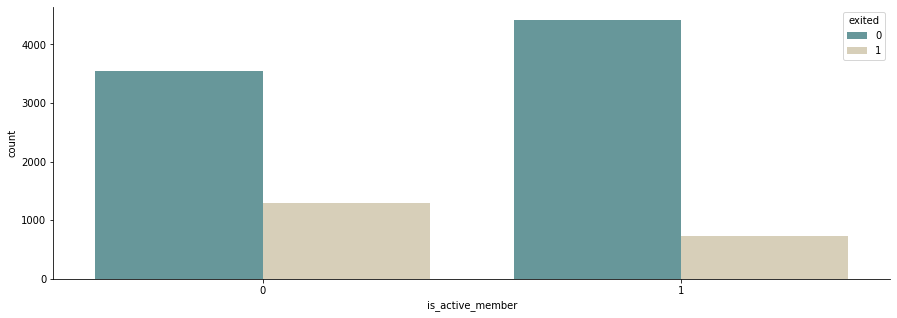

In [153]:
# figure
plt.figure(figsize=(15, 5))
sns.countplot(x='is_active_member', hue='exited', data=df4, palette=palette)
sns.despine(right=True)

### H6.  Clientes que compraram menos de 2 produtos, entram mais em Churn. 

**VERDADEIRA** Clientes que compraram <ins>menos</ins> de 2 produtos, entram mais em Churn. 

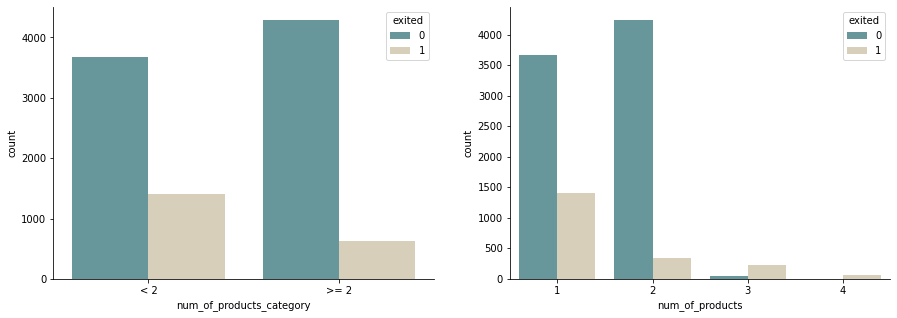

In [154]:
# first figure
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='num_of_products_category', hue='exited', data=df4, palette=palette)
sns.despine(right=True)

# second figure
plt.subplot(1, 2, 2)
sns.countplot(x='num_of_products', hue='exited', data=df4, palette=palette)
sns.despine(right=True)

### **H7.** Clientes que permaneceram ativos por menos de 3 anos, entram mais em Churn.

**VERDADEIRO** Clientes que permaneceram ativos por menos de 3 anos, entram mais em Churn.

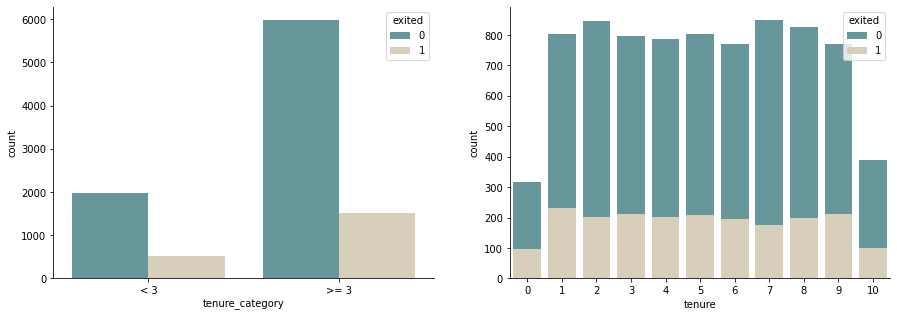

In [155]:
# first figure
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='tenure_category', hue='exited', data=df4, palette=palette)
sns.despine(right=True)

# second figure
plt.subplot(1, 2, 2)
sns.countplot(x='tenure', hue='exited', data=df4, dodge=False, palette=palette)
sns.despine(right=True)

### **H8.** Clientes que ficam com a conta zerada, entram mais em Churn.

**FALSA** Clientes que <ins>não ficam</ins> com a conta zerada, entram mais em Churn.

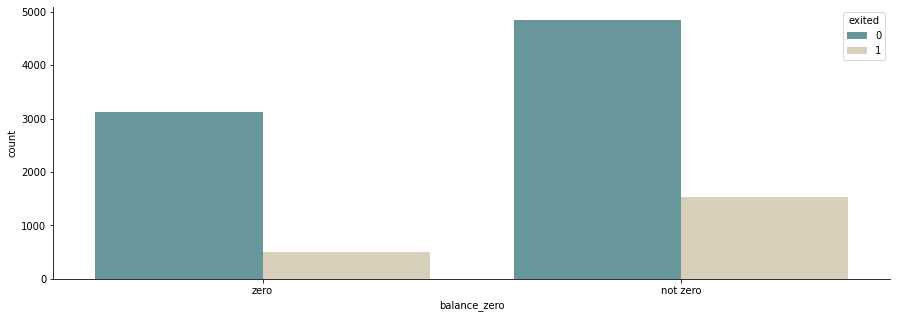

In [156]:
# figure
plt.figure(figsize=(15, 5))
sns.countplot(x='balance_zero', hue='exited', data=df4, palette=palette)
sns.despine(right=True)

### **H9.** Clientes que possuem valor menor que a mediana na conta, entram mais em Churn. 

**FALSA** Clientes que possuem valor <ins>maior</ins> que a mediana na conta, entram mais em Churn. 

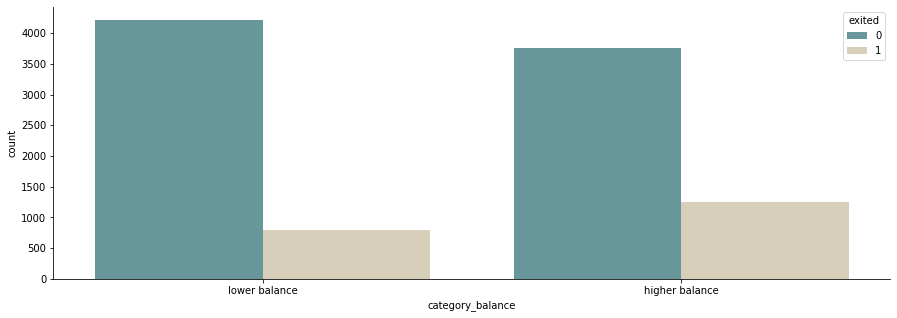

In [157]:
# figure
plt.figure(figsize=(15, 5))
sns.countplot(x='category_balance', hue='exited', data=df4, palette=palette)
sns.despine(right=True)

### **H10.** Clientes que não possuem cartão de crédito, entram mais em Churn.

**FALSA** Clientes que <ins>possuem</ins> cartão de crédito, entram mais em Churn.

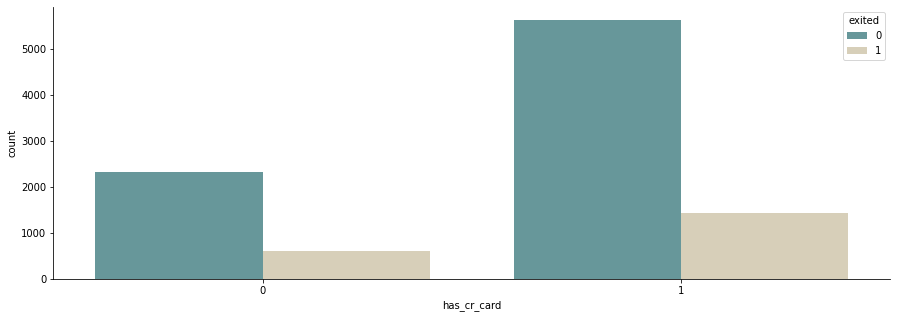

In [158]:
# figure
plt.figure(figsize=(15, 5))
sns.countplot(x='has_cr_card', hue='exited', data=df4, palette=palette)
sns.despine(right=True)

### **H11.** Clientes com menor saldo, entram mais em Churn.

**FALSA** Clientes com <ins>maior saldo</ins>, entram mais em Churn.

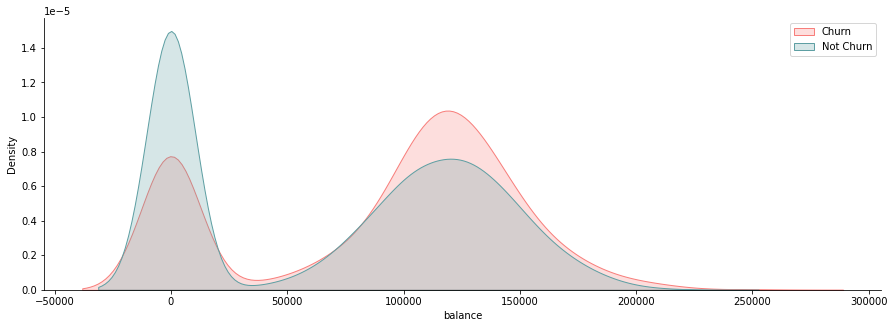

In [159]:
# create figure kdeplot
plt.figure(figsize=(15, 5))
sns.kdeplot(x=df4[df4['exited'] == 1]['balance'], label='Churn', shade=True, color=palette[3])
sns.kdeplot(x=df4[df4['exited'] == 0]['balance'], label='Not Churn', shade=True, color=palette[0])
sns.despine(right=True)
plt.legend();

### H12. Clientes com poder aquisitivo baixo, entram mais em Churn.

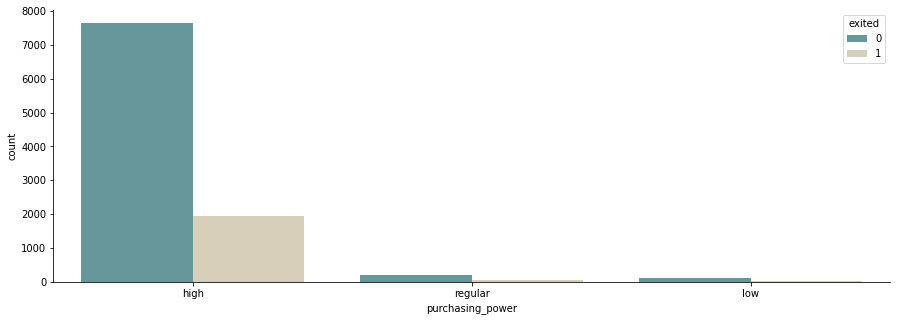

In [160]:
plt.figure(figsize=(15, 5))
sns.countplot(x='purchasing_power', data=df4, hue='exited', palette=palette)
sns.despine(right=True);

### H13. Clientes que trazem maior retorno, entram mais em Churn.

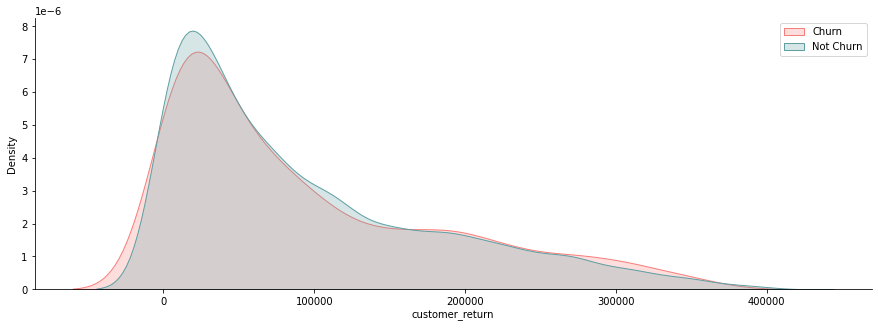

In [161]:
# figure
plt.figure(figsize=(15, 5))
sns.kdeplot(x=df4[df4['exited'] == 1]['customer_return'], label='Churn', shade=True, color=palette[3])
sns.kdeplot(x=df4[df4['exited'] == 0]['customer_return'], label='Not Churn', shade=True, color=palette[0])
sns.despine(right=True)
plt.legend();

## 4.3 Análise Multivariada

### 4.3.1 Variavel Numérica

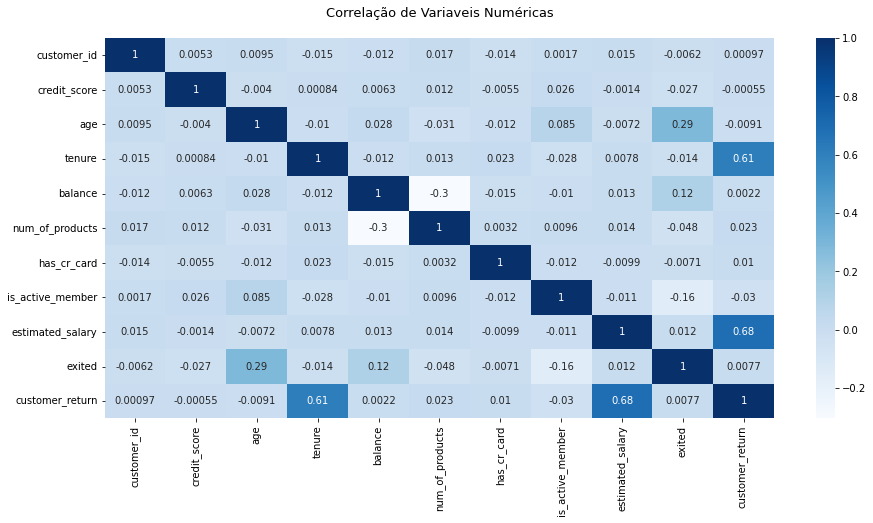

In [162]:
# filter numerical attributes
num = df4.select_dtypes(include=['int64', 'float64'])

# plot correlation
plt.figure(figsize=(15, 7))
sns.heatmap(num.corr(method='pearson'), annot=True, cmap='Blues')
plt.title('Correlação de Variaveis Numéricas\n', fontsize=13);

**Insight:**

variavel exited:

- Há uma correlação negativa com a saída do cliente, e se ele é um membro ativo do banco.

- Há uma correlação positiva fraca com a saída do cliente e o saldo na conta.

- Há uma correlação positiva média com a saída do cliente e a sua idade.

outras variaveis:

- Há uma correlação negativa com o saldo na conta e o numero de produtos.
- Há uma correlação fraca com a idade do cliente, e se ele é um membro ativo.

### 4.3.2 Variavel Categórica

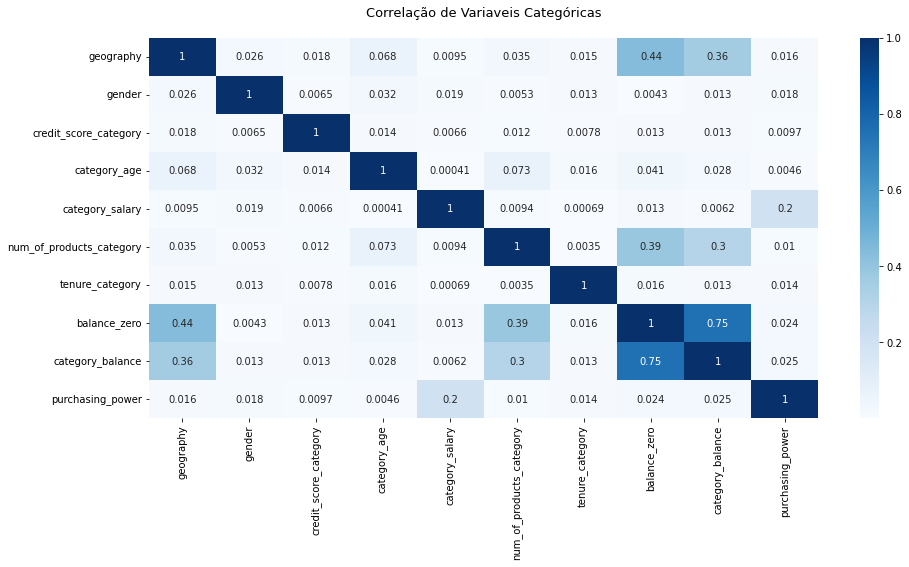

In [163]:
# Categorical data
categorical = df4.select_dtypes(include=['object'])

# Apply correlation categories
matrix = show_matrix(data=categorical, col='geography', output='dict')
data_columns = categorical.iloc[:, 1:]

for c in data_columns.columns:
    matrix[c] = show_matrix(data=categorical, col=c, output='list')

# create figure
plt.figure(figsize=(15, 7))
sns.heatmap(matrix, annot=True, cmap='Blues')
plt.title('Correlação de Variaveis Categóricas\n', fontsize=13);

**Insight:**

- Há uma correlação média com o saldo zerado e o país do cliente.
- Há uma correlação média com a categoria do balanço e o país do cliente.
- Há uma correlação fraca com a categoria do salario e o poder de compra do cliente.
- Há uma correlação média com a categoria de produtos adquiridos e o saldo zerado.
- Há uma correlaçaõ forte entre o saldo zerado e a categoria do saldo.

# 5.0 PREPARAÇÃO DE DADOS

## 5.1 Divisão de Dados

Como a amostra de dados é pequena, os dados serão divididos entre treino e teste. Sendo 80% da amostra para realizar o treinamento do modelo e 20% para o teste.

In [164]:
df5 = df4.copy() # copy data to section 5

feature = df5.drop(columns=['exited']) # x/features
target = df5['exited'] # y/target

# split data
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.20, random_state=42)

# copy data to API test 
send_api = x_test.copy()

# drop id in x
x_train.drop(columns='customer_id', inplace=True)
x_test.drop(columns='customer_id', inplace=True)

## 5.2 Dados de Treinamento

Para não correr o risco ter algum vazamento de dados, a preparação dos dados será divida entre treinamento e teste.

Nesta seção, será feito a preparação dos dados de treinamento.

### 5.2.1 Reescalonamento

#### 5.2.1.1 Min Max Scaler

A abordagem de Min Max Scaler transforma os dados para um intervalo entre 0 e 1.

In [165]:
# define method
mms_balance = MinMaxScaler()
mms_salary = MinMaxScaler()

# balance
x_train['balance'] = mms_balance.fit_transform(x_train[['balance']].values)

# estimated_salary
x_train['estimated_salary'] = mms_salary.fit_transform(x_train[['estimated_salary']].values)

#### 5.2.1.2 Robust Scaler

A abordagem de Roboust Scaler transforma os dados para um intervalo entre o 1º quartil e o 3º.

In [166]:
# define method
rs_age = RobustScaler()
rs_customer_return = RobustScaler()

# age
x_train['age'] = rs_age.fit_transform(x_train[['age']].values)

# customer_return
x_train['customer_return'] = rs_customer_return.fit_transform(x_train[['customer_return']].values)

#### 5.2.1.3 Standard Scaler

A abordagem de Standard Scaler transforma a média para 0 e o desvio padrão para 1, transformando os dados para a variância da unidade.

In [167]:
# define method
sc_credit_score = StandardScaler()

# credit_score
x_train['credit_score'] = sc_credit_score.fit_transform(x_train[['credit_score']].values)

### 5.2.2 Encoding

#### 5.2.2.1 One Hot Encoding

A técnica One Hot Encoding mapeia a variavel categórica com novas variaveis binárias contendo 0: representando a Não existência do valor ou 1: representando a existência do valor.

In [168]:
# geography
x_train = pd.get_dummies(x_train, prefix='geography', columns=['geography'])

# purchasing_power
x_train = pd.get_dummies(x_train, prefix='purchasing_power', columns=['purchasing_power'])

#### 5.2.2.2  Binary Encoding

A técnica Binary Encoding mapeia a variavel categórica binaria como "sim" ou "não", para valores numéricos 0 ou 1. Ou seja, 1 = sim, 0 = não.

In [169]:
# gender
x_train['gender'] = x_train['gender'].apply(lambda x: 1 if x == 'Female' else 0)

# category_age
x_train['category_age'] = x_train['category_age'].map({'>= 40': 1, '< 40': 0})

# category_salary
x_train['category_salary'] = x_train['category_salary'].map({'lower salary': 0, 'higher salary': 1})

# num_of_products_category
x_train['num_of_products_category'] = x_train['num_of_products_category'].map({'< 2': 0, '>= 2': 1})

# tenure_category
x_train['tenure_category'] = x_train['tenure_category'].map({'< 3': 0, '>= 3': 1})

# balance_zero
x_train['balance_zero'] = x_train['balance_zero'].map({'zero': 0, 'not zero': 1})

# category_balance
x_train['category_balance'] = x_train['category_balance'].map({'lower balance': 0, 'higher balance': 1})

#### 5.2.2.3 Label Encoding

A técnica Label Encoding transforma a variavel em um range de números inteiros (sequência numérica).

In [170]:
# credit_score_category
x_train['credit_score_category'] = x_train['credit_score_category'].map({'ruim': 0, 'regular': 1, 'bom': 2})

## 5.3 Dados de Teste

Nesta seção, será feito a preparação dos dados de teste.

### 5.3.1 Reescalonamento

#### 5.3.1.1 Min Max Scaler

A abordagem de Min Max Scaler transforma os dados para um intervalo entre 0 e 1 ou -1 a 1.

In [82]:
# define method
mms_balance_test = MinMaxScaler()
mms_salary_test = MinMaxScaler()

# balance
x_test['balance'] = mms_balance_test.fit_transform(x_test[['balance']].values)

# estimated_salary
x_test['estimated_salary'] = mms_salary_test.fit_transform(x_test[['estimated_salary']].values)

#### 5.3.1.2 Robust Scaler

A abordagem de Roboust Scaler transforma os dados para um intervalo entre o 1º quartil e o 3º.

In [83]:
# define method
rs_age_test = RobustScaler()
rs_customer_return_test = RobustScaler()

# age
x_test['age'] = rs_age_test.fit_transform(x_test[['age']].values)

# customer_return
x_test['customer_return'] = rs_customer_return_test.fit_transform(x_test[['customer_return']].values)

#### 5.3.1.3 Standard Scaler

A abordagem de Standard Scaler transforma a média para 0 e o desvio padrão para 1, transformando os dados para a variância da unidade.

In [84]:
# define method
sc_credit_score_test = StandardScaler()

# credit_score
x_test['credit_score'] = sc_credit_score_test.fit_transform(x_test[['credit_score']].values)

### 5.3.2 Encoding

#### 5.3.2.1 One Hot Encoding

A técnica One Hot Encoding mapeia a variavel categórica com novas variaveis binárias contendo 0: representando a Não existência do valor ou 1: representando a existência do valor.

In [85]:
# geography
x_test = pd.get_dummies(x_test, prefix='geography', columns=['geography'])

# purchasing_power
x_test = pd.get_dummies(x_test, prefix='purchasing_power', columns=['purchasing_power'])

#### 5.3.2.2 Binary Encoding

A técnica Binary Encoding mapeia a variavel categórica binaria como "sim" ou "não", para valores numéricos 0 ou 1. Ou seja, sim = 1, não = 0.

In [86]:
# gender
x_test['gender'] = x_test['gender'].apply(lambda x: 1 if x == 'Female' else 0)

# category_age
x_test['category_age'] = x_test['category_age'].map({'>= 40': 1, '< 40': 0})

# category_salary
x_test['category_salary'] = x_test['category_salary'].map({'lower salary': 0, 'higher salary': 1})

# num_of_products_category
x_test['num_of_products_category'] = x_test['num_of_products_category'].map({'< 2': 0, '>= 2': 1})

# tenure_category
x_test['tenure_category'] = x_test['tenure_category'].map({'< 3': 0, '>= 3': 1})

# balance_zero
x_test['balance_zero'] = x_test['balance_zero'].map({'zero': 0, 'not zero': 1})

# category_balance
x_test['category_balance'] = x_test['category_balance'].map({'lower balance': 0, 'higher balance': 1})

#### 5.3.2.3 Label Encoding

A técnica Label Encoding transforma a variavel em um range de números inteiros (sequência numérica).

In [87]:
# credit_score_category
x_test['credit_score_category'] = x_test['credit_score_category'].map({'ruim': 0, 'regular': 1, 'bom': 2})

# 6.0 SELEÇÃO DE FEATURE

Nesta seção, será feito a seleção das melhores features com o objetivo de reduzir a dimensionalidade e entregar ao modelo as features com maior capacidade de aprendizagem sobre o fonemono de Churn da empresa.

## 6.1 Feature Importance

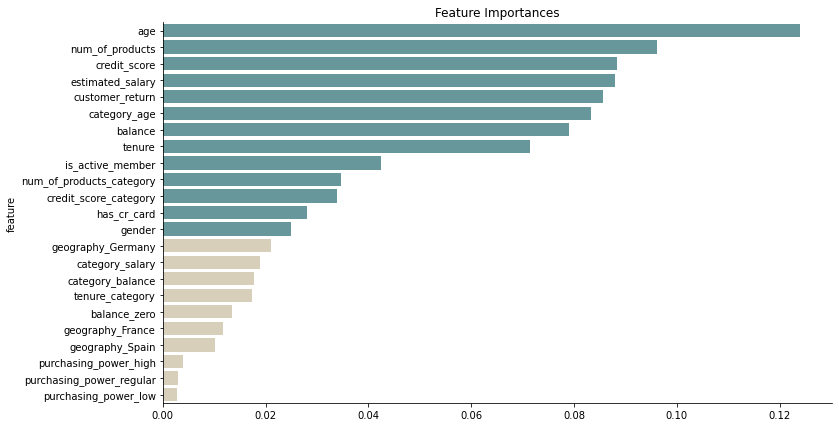

In [90]:
# define model
extraTrees = ExtraTreesClassifier()

# training model
extraTrees_trained = extraTrees.fit(x_train, y_train)

# show importance to Extra Tress
importance = extraTrees_trained.feature_importances_ 
indices = np.argsort(importance)[::-1] 

# interate to save in dataframe the importance of all columns
df = pd.DataFrame()
for i, j in zip(x_train, extraTrees_trained.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df  = pd.concat([df, aux], axis=0)

# sort by importance value
df = df.sort_values(by='importance', ascending=False)

# adjust color to columns selected
color = []
count = 0
for i in range(len(df)):
    count += 1
    if count <= 13: # position to columns selected
        color.append(palette[0])
    else:
        color.append(palette[1])

# Create figure to show feature importance  
plt.figure(figsize=(12, 7))
sns.barplot(y='feature', x='importance', data=df, order=df['feature'], palette=color)
sns.despine(right=True)
plt.title('Feature Importances')
plt.xlabel('');

## 6.2 Boruta

,Selected
0,credit_score
1,age
2,balance
3,num_of_products
4,is_active_member
5,category_age
6,num_of_products_category


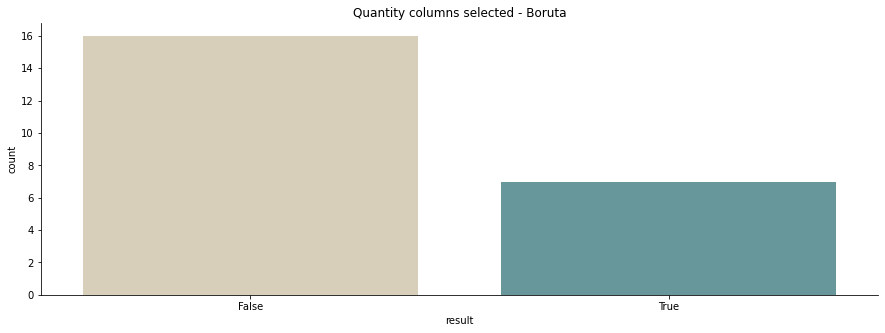

In [93]:
# Define Boruta
boruta = BorutaPy(extraTrees, n_estimators='auto', verbose=0, random_state=42)

# training boruta
boruta_trained = boruta.fit(x_train.values, y_train.values)


# Selected Boruta
result = boruta_trained.support_.tolist()

# Best Features
selected = x_train.iloc[:, result].columns.to_list()

# Columns Not Selected Boruta
not_selected = list(np.setdiff1d(x_train.columns, selected))

# save columns selected in dataframe
resume = pd.DataFrame({'columns': x_train.columns, 'result': result})
reseume_selected = pd.DataFrame({'Selected': selected})

# plot quantity selected columns and not selected
plt.figure(figsize=(15, 5))
sns.countplot(x='result', data=resume, palette=[palette[1], palette[0]])
plt.title('Quantity columns selected - Boruta')
sns.despine(right=True)

# show
reseume_selected

## 6.3 Filtragem de Variaveis

In [94]:
# selected by feature importance
cols_selected_importance = ['age', 'credit_score', 'estimated_salary', 'num_of_products', 'customer_return',
                            'category_age', 'balance', 'tenure', 'is_active_member', 'credit_score_category',
                            'num_of_products_category', 'has_cr_card', 'gender']

# selected by boruta
cols_selected_boruta = ['age', 'balance', 'is_active_member', 'category_age', 'num_of_products_category', 'num_of_products']

# concat selected by feature importance and selected by boruta
cols_selected_final = list(set(cols_selected_importance + cols_selected_boruta))

# filter columns in training and test
x_train = x_train[cols_selected_final]
x_test = x_test[cols_selected_final]

# 7.0 MACHINE LEARNING

Esta seção será usada para treinamento dos modelos com os dados preparados e a avaliação usando 2 métricas principais e 2 curvas. 


Mértricas:

- **Precision @k k=50**: De todos os exemplos que a predição foi verdadeira até K (20 mil clientes), quantos realmente eram verdadeira? Ou seja: Contar quantas predições foram corretas até K e dividir por todas as predições realizadas pelo modelo até K.


- **Recall @k k=50**: De todos os exemplos que realmente são verdadeiros, quantos a predição foi verdadeira? Ou seja, contar quantas predições foram corretas até K e dividir por todos os exemplos verdadeiros.

Curvas:

- **Curva Lift**: Avalia quantas vezes o modelo é melhor do que um modelo aleatório, ou seja, quantas vezes o modelo é melhor em identificar Churn ao invés de escolhermos clientes aleatórios na base.


- **Curva de ganho acumulativo**: Avalia quantos clientes em Churn o modelo consegue atingir com um incentivo de 50 cupons de descontos. Eixo x: % de cupons/clientes. Eixo y: % de churn.

## 7.1 Naive Bayes

Precision_topk_50: 0.8235294117647058
Recall_topk_50: 0.10687022900763359


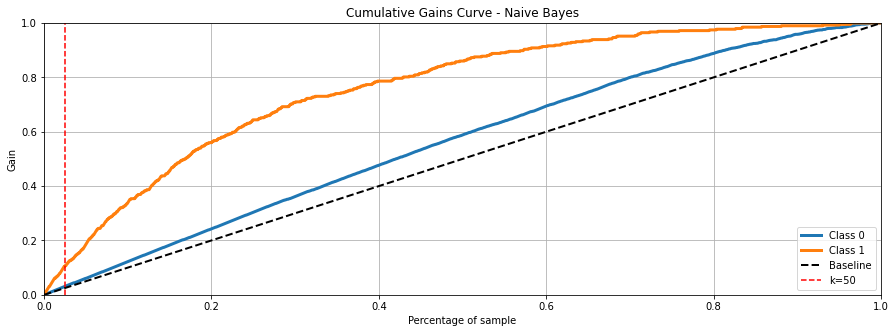

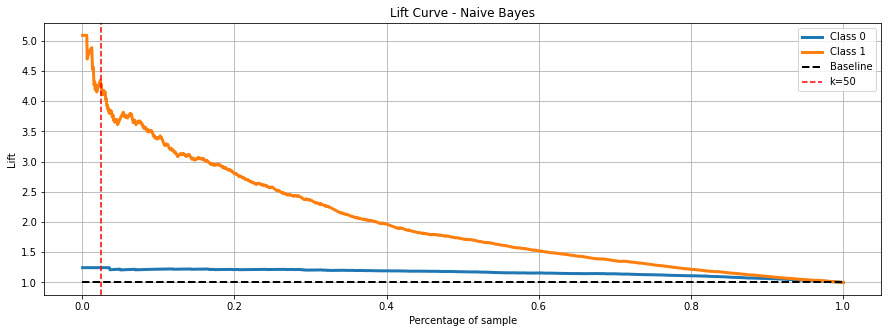

In [101]:
# define naive bayes
naive_bayes = GaussianNB()

# training model
bayes_trained = naive_bayes.fit(x_train, y_train)

# predict model
yhat_bayes = bayes_trained.predict_proba(x_test)

# Compute metrics
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test=x_test, y_test=y_test, yhat=yhat_bayes, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test=x_test, y_test=y_test, yhat=yhat_bayes, k=k))

# plot curve
plot_curve('Naive Bayes', y_pred=yhat_bayes, y_true=y_test)

**Insight:**

- Dentro dos 50 clientes que o Naive Bayes ordenou/Ranqueou, 82% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 10% de todos os casos de Churn.

- O naive Bayes é 4x melhor que um modelo aleatório.

### 7.1.1 Cross Validation - Naive Bayes

In [102]:
# data to cross validation
x_full = pd.concat([x_train, x_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

bayes_cv = cross_validation(model_name='Naive Bayes CV', x=x_full, y=y_full, model=naive_bayes, cv=5, k=k, verbose=True)
bayes_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,Naive Bayes CV,50,0.811765,0.101618


**Insight:**

A performance real dentro dos 50 clientes que o Naive Bayes ordenou/Ranqueou, 81% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 10% de todos os casos de Churn.

## 7.2 Logistic Regression

Precision_topk_50: 0.8823529411764706
Recall_topk_50: 0.11450381679389313


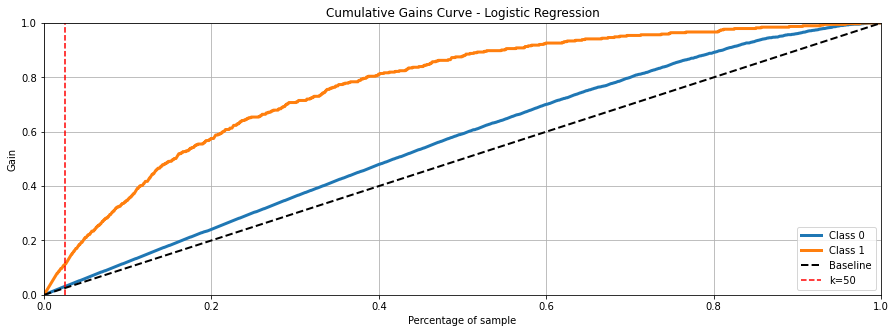

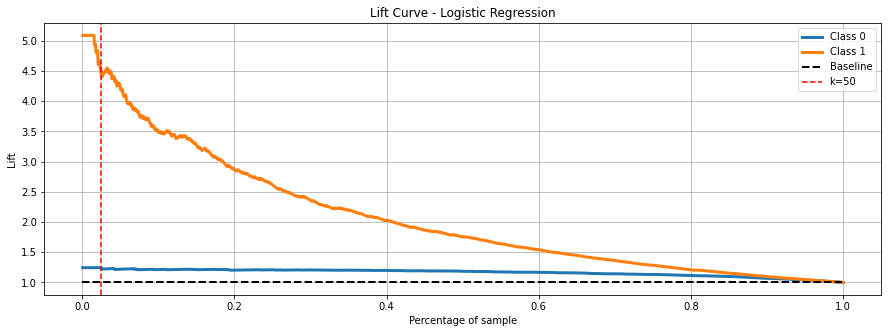

In [103]:
# define model
lr = LogisticRegression()

# training and predict
lr_trained = lr.fit(x_train, y_train)
yhat_lr = lr_trained.predict_proba(x_test)

# Compute metrics
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test=x_test, y_test=y_test, yhat=yhat_lr, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test=x_test, y_test=y_test, yhat=yhat_lr, k=k))

# plot curve
plot_curve('Logistic Regression', y_pred=yhat_lr, y_true=y_test)

**Insight:**

- Dentro dos 50 clientes que a Regressão Logística ordenou/Ranqueou, 88% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 11% de todos os casos de Churn.


- A Regressão Logística é 4.5x melhor que um modelo aleatório.

### 7.2.1 Logistic Regression - Cross Validation

In [104]:
lr_cv = cross_validation(model_name='Logistic Regression CV', x=x_full, y=y_full, model=lr, cv=5, k=k, verbose=True)
lr_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,Logistic Regression CV,50,0.921569,0.115366


**Insight:**

A performance real dentro dos 50 clientes que a Regresão Logística ordenou/Ranqueou, 92% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 11% de todos os casos de Churn.

## 7.3 KNN

Precision_topk_50: 0.8627450980392157
Recall_topk_50: 0.10941475826972011


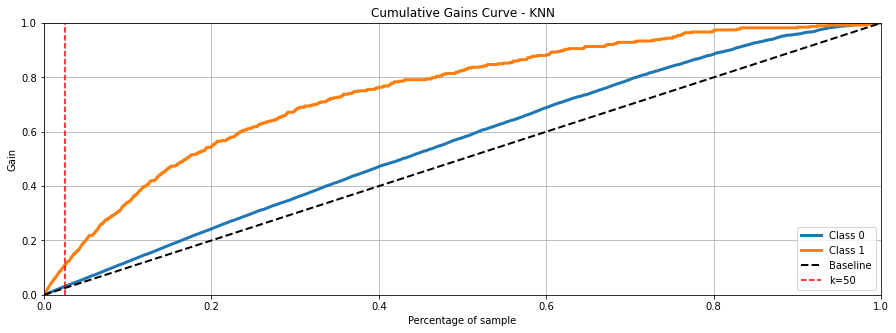

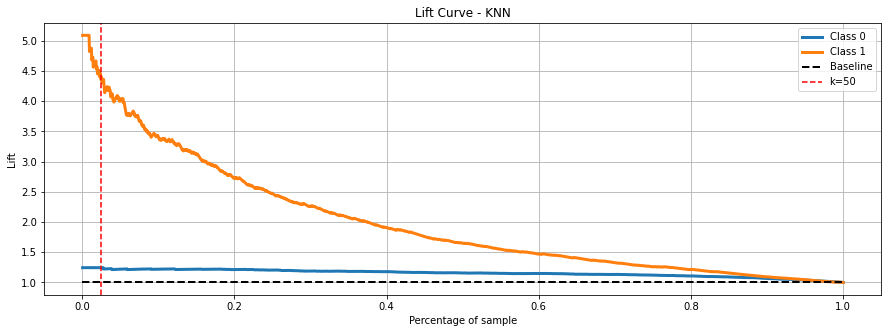

In [105]:
# define model
knn = KNeighborsClassifier(n_neighbors=20)

# training and predict
knn_trained = knn.fit(x_train, y_train)
yhat_knn = knn_trained.predict_proba(x_test)

# Compute metrics
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test=x_test, y_test=y_test, yhat=yhat_knn, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test=x_test, y_test=y_test, yhat=yhat_knn, k=k))

# plot curve
plot_curve('KNN', y_pred=yhat_knn, y_true=y_test)

**Insight:**

- Dentro dos 50 clientes que o KNN ordenou/Ranqueou, 86% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 10% de todos os casos de Churn.


- O KNN é 4.3x melhor que um modelo aleatório.

### 7.3.1 KNN - Cross Validation

In [106]:
knn_cv = cross_validation(model_name='KNN CV', x=x_full, y=y_full, model=knn, cv=5, k=k, verbose=True)
knn_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,KNN CV,50,0.843137,0.104562


**Insight:**

A performance real dentro dos 50 clientes que o KNN ordenou/Ranqueou, 84% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 10% de todos os casos de Churn.

## 7.4 Random Forest

Precision_topk_50: 0.9411764705882353
Recall_topk_50: 0.12213740458015267


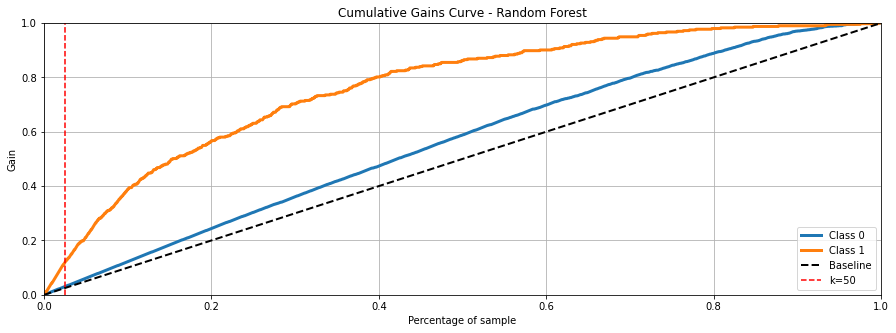

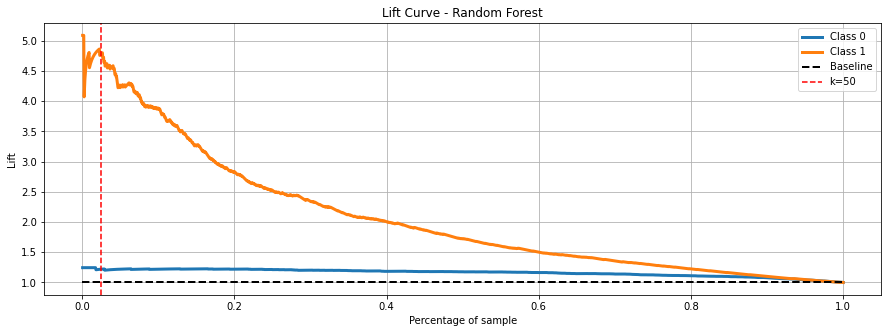

In [107]:
# define model
rf = RandomForestClassifier()

# training and predict
rf_trained = rf.fit(x_train, y_train)
yhat_rf = rf_trained.predict_proba(x_test)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test=x_test, y_test=y_test, yhat=yhat_rf, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test=x_test, y_test=y_test, yhat=yhat_rf, k=k))

# plot curve
plot_curve('Random Forest', y_pred=yhat_rf, y_true=y_test)

**Insight:**

- Dentro dos 50 clientes que a Random Forest ordenou/Ranqueou, 92% eram de fato Churn e dentro do ranqueamento, conseguiu pegar quase 12% de todos os casos de Churn.


- A Random Forest é 4.7x melhor que um modelo aleatório.

### 7.4.1 Random Forest - Cross Validation

In [108]:
rf_cv = cross_validation(model_name='Random Forest CV', x=x_full, y=y_full, model=rf, cv=5, k=k, verbose=True)
rf_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,Random Forest CV,50,0.945098,0.118802


**Insight:**

A performance real dentro dos 50 clientes que a Random Forest ordenou/Ranqueou, 94% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 11% de todos os casos de Churn.

## 7.5 XGBoost

Precision_topk_50: 0.9803921568627451
Recall_topk_50: 0.1272264631043257


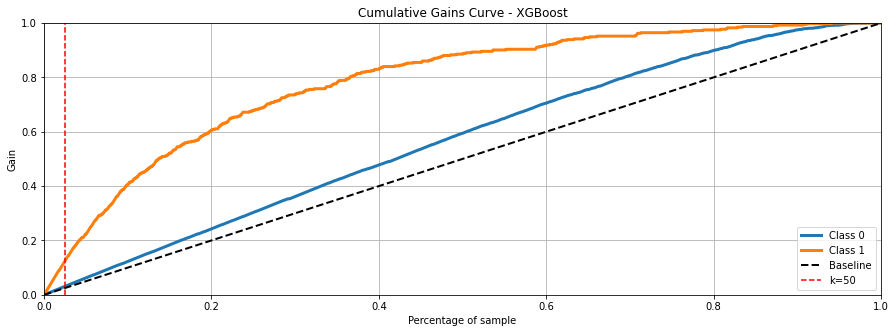

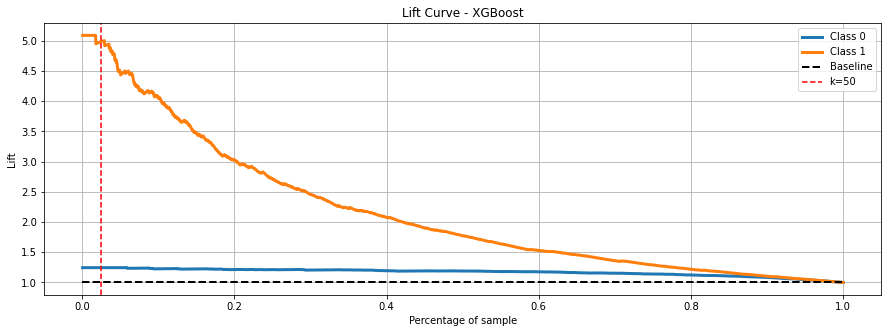

In [109]:
# define model
xgboost = xgb.XGBClassifier()

# training and predict
xgboost_trained = xgboost.fit(x_train, y_train)
yhat_xgboost = xgboost_trained.predict_proba(x_test)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test=x_test, y_test=y_test, yhat=yhat_xgboost, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test=x_test, y_test=y_test, yhat=yhat_xgboost, k=k))

# plot curve
plot_curve('XGBoost', y_pred=yhat_xgboost, y_true=y_test)

**Insight:**

- Dentro dos 50 clientes que o XGBoost ordenou/Ranqueou, 98% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 12% de todos os casos de Churn.


- O XGBoost é 5x melhor que um modelo aleatório.

### 7.5.1 XGBoost - Cross Validation

In [110]:
xgboost_cv = cross_validation(model_name='XGBoost CV', x=x_full, y=y_full, model=xgboost, cv=5, k=k, verbose=True)
xgboost_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,XGBoost CV,50,0.968627,0.121258


**Insight:**

A performance real dentro dos 50 clientes que o XGBoost ordenou/Ranqueou, 96% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 12% de todos os casos de Churn.

## 7.6 LGBM

Precision_topk_50: 0.9607843137254902
Recall_topk_50: 0.12468193384223919


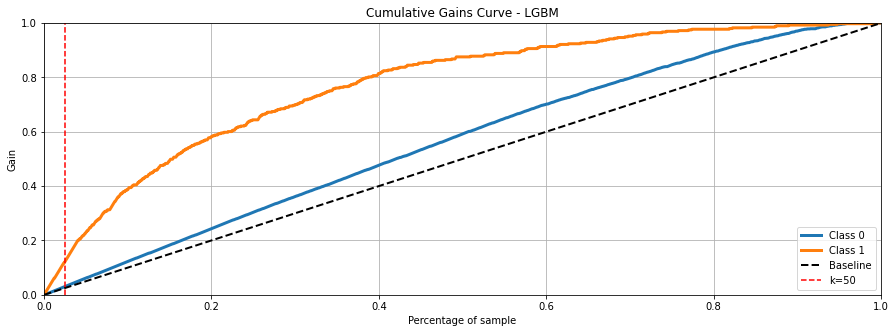

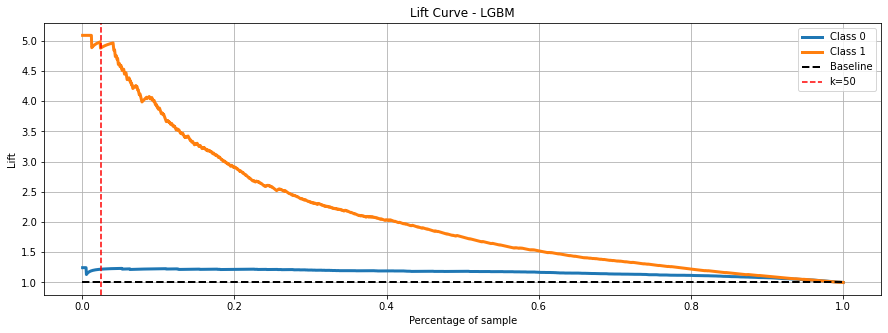

In [111]:
# define model
lgbm = LGBMClassifier()

# training and predict
lgbm_trained = lgbm.fit(x_train, y_train)
yhat_lgbm = lgbm_trained.predict_proba(x_test)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test=x_test, y_test=y_test, yhat=yhat_lgbm, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test=x_test, y_test=y_test, yhat=yhat_lgbm, k=k))

# plot curve
plot_curve('LGBM', y_pred=yhat_lgbm, y_true=y_test)

**Insight:**

- Dentro dos 50 clientes que o LGBM ordenou/Ranqueou, 96% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 12% de todos os casos de Churn.


- O LGBM é quase 5x melhor que um modelo aleatório.

### 7.6.1 LGBM - Cross Validation

In [112]:
lgbm_cv = cross_validation(model_name='LGBM CV', x=x_full, y=y_full, model=lgbm, cv=5, k=k, verbose=True)
lgbm_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,LGBM CV,50,0.964706,0.120766


**Insight:**

A performance real dentro dos 50 clientes que o LGBM ordenou/Ranqueou, 96% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 12% de todos os casos de Churn.

## 7.7 Combinação de Modelos (XGB, RF, LGBM) 

Precision_topk_50: 0.9803921568627451
Recall_topk_50: 0.1272264631043257


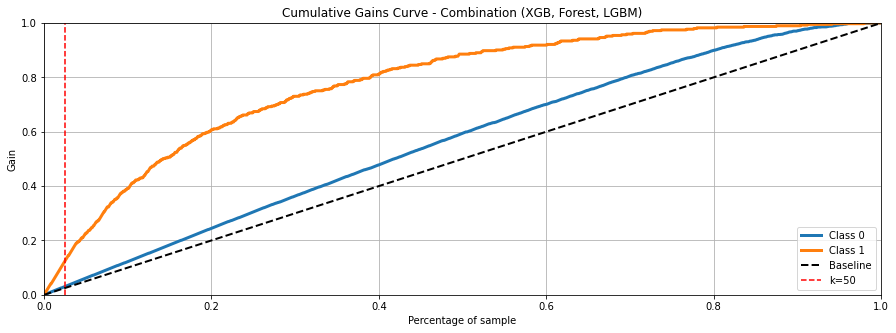

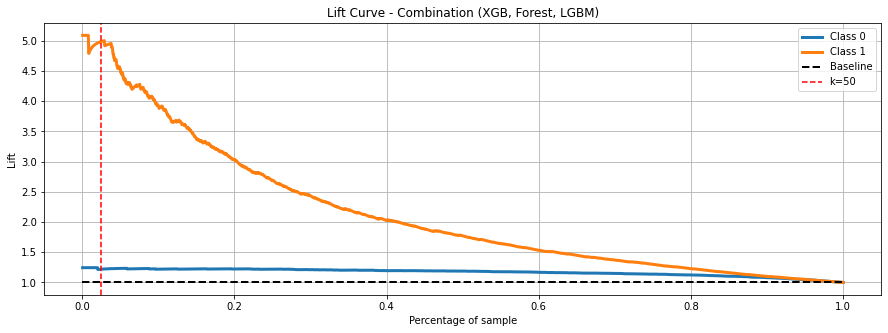

In [113]:
xgboost = xgb.XGBClassifier()
rf = RandomForestClassifier()
lgbm = LGBMClassifier()

models = [('xgb', xgboost), ('forest', rf), ('lgbm', lgbm)]
models_combined = VotingClassifier(models, voting='soft')

models_combined_trained = models_combined.fit(x_train, y_train)
yhat_models_combined = models_combined_trained.predict_proba(x_test)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test=x_test, y_test=y_test, yhat=yhat_models_combined, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test=x_test, y_test=y_test, yhat=yhat_models_combined, k=k))

# plot curve
plot_curve('Combination (XGB, Forest, LGBM)', y_pred=yhat_models_combined, y_true=y_test)

**Insight:**

- Dentro dos 50 clientes que a combinação de modelos ordenou/Ranqueou, 98% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 12% de todos os casos de Churn.


- A combinação de modelos é 5x melhor que um modelo aleatório.

### 7.7.1 Combinação de Modelos (XGB, RF, LGBM) - Cross Validation

In [114]:
models_combined_cv = cross_validation(model_name='Combination (XGB, Forest, LGBM) CV', x=x_full, y=y_full, model=models_combined, cv=5, k=k, verbose=True)
models_combined_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,"Combination (XGB, Forest, LGBM) CV",50,0.968627,0.121257


**Insight:**

A performance real dentro dos 50 clientes que a combinação de modelos ordenou/Ranqueou, 96% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 12% de todos os casos de Churn.

## 7.8 Comparação Performance

In [115]:
performance_cv = pd.concat([bayes_cv, lr_cv, knn_cv, rf_cv, xgboost_cv, lgbm_cv, models_combined_cv], axis=0)
performance_cv.sort_values(by='recall_top_at', ascending=False)

,model_name,number of K,precision_top_at,recall_top_at
0,XGBoost CV,50,0.968627,0.121258
0,"Combination (XGB, Forest, LGBM) CV",50,0.968627,0.121257
0,LGBM CV,50,0.964706,0.120766
0,Random Forest CV,50,0.945098,0.118802
0,Logistic Regression CV,50,0.921569,0.115366
0,KNN CV,50,0.843137,0.104562
0,Naive Bayes CV,50,0.811765,0.101618


**Insight:**

Os modelos XGBoost, LGBM e a combinação de modelos possuem resultados bem próximos e por pouco a combinação de modelos não está em 1º lugar como melhor modelo. Mesmo assim, a combinação será usada como modelo final com o objetivo de melhorar a performance com ajuste de hiperparametros.

# 8.0 AJUSTE DE HIPERPARAMETROS

## 8.1 Grid Search

In [63]:
# test parameters XGB
parameters_xgb = {
    'min_child_weight': [3, 8, 15],
    'n_estimators': [500, 1000, 1500], 
    'max_depth': [5, 7, 9]
}

# test parameters Random Forest
parameters_rf = {
    'min_child_weight': [3, 8, 15],
    'n_estimators': [500, 1000, 1500], 
    'max_depth': [5, 7, 9]
}

# test parameters LGBM
parameters_lgbm = {
    'min_child_weight': [3, 8, 15],
    'n_estimators': [500, 1000, 1500], 
    'max_depth': [5, 7, 9]
}


# apply grid search in XGB
search_xgb = grid_search(
            min_child_weight=parameters_xgb['min_child_weight'],
            n_estimators=parameters_xgb['min_child_weight'],
            max_depth=parameters_xgb['max_depth'], 
            model_name='XGB Search', model='xgboost'
        )
print('GRID SEARCH - XGBOOST')
print(search_xgb, '\n')

# apply grid search in Random Forest
search_rf = grid_search(
            min_child_weight=parameters_rf['min_child_weight'],
            n_estimators=parameters_rf['min_child_weight'],
            max_depth=parameters_rf['max_depth'], 
            model_name='RF Search', model='forest'
        )
print('GRID SEARCH - RANDOM FOREST', '\n')
print(search_rf)

# apply grid search in LGBM
search_lgbm = grid_search(
            min_child_weight=parameters_lgbm['min_child_weight'],
            n_estimators=parameters_lgbm['min_child_weight'],
            max_depth=parameters_lgbm['max_depth'], 
            model_name='LGBM Search', model='lgbm'
        )
print('GRID SEARCH - LGBM', '\n')
print(search_lgbm)

GRID SEARCH - XGBOOST
   model_name  number of K  precision_top_at  recall_top_at  min_child_weight  \
0  XGB Search          200          0.791045       0.390274                 3   
0  XGB Search          200          0.790050       0.389788                 3   
0  XGB Search          200          0.790050       0.389785                 3   
0  XGB Search          200          0.789055       0.389293                 8   
0  XGB Search          200          0.788060       0.388803                 8   

   n_estimators  max_depth  cross_validation  
0            15          5                 5  
0            15          9                 5  
0            15          7                 5  
0             8          5                 5  
0             3          5                 5   

GRID SEARCH - RANDOM FOREST 

  model_name  number of K  precision_top_at  recall_top_at  min_child_weight  \
0  RF Search          200          0.797015       0.393213                15   
0  RF Search     

**Insight:**

A melhor combinação de hiperparametros para o modelo XGBoost:
- min_child_weight: 3
- n_estimators: 15  
- max_depth: 5

A melhor combinação de hiperparametros para o modelo Random Forest:
- min_samples_split: 15
- n_estimators: 15  
- max_depth: 9

A melhor combinação de hiperparametros para o modelo LGBM:
- min_child_weight: 3
- n_estimators: 15  
- max_depth: 5

## 8.2 Modelo Final

### 8.2.1 Treinamento

In [116]:
# define models with best parameters to combination
xgboost = xgb.XGBClassifier(min_child_weight=3, n_estimators=15, max_depth=5)
rf = RandomForestClassifier(min_samples_split=15, n_estimators=15, max_depth=9)
lgbm = LGBMClassifier(min_child_weight=3, n_estimators=15, max_depth=5)

# model combination 
models = [('xgb', xgboost), ('forest', rf), ('lgbm', lgbm)]
model_final = VotingClassifier(models, voting='soft')

# training model combination final
model_final_trained = model_final.fit(x_train.values, y_train.values)

### 8.2.2 Teste

Precision_topk_50: 0.9803921568627451
Recall_topk_50: 0.1272264631043257


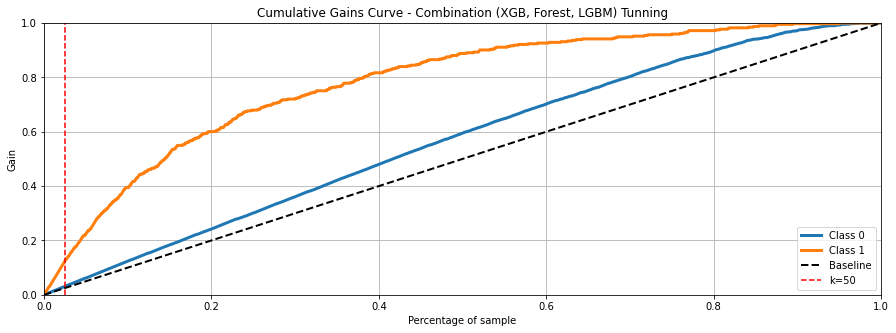

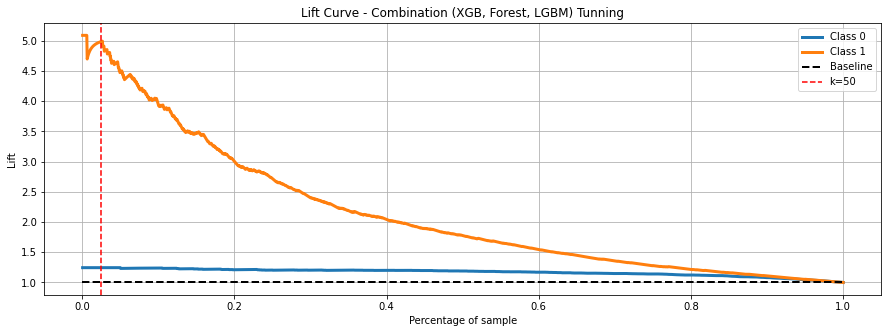

In [117]:
# model combination predict
yhat_model_final = model_final_trained.predict_proba(x_test.values)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test=x_test, y_test=y_test, yhat=yhat_model_final, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test=x_test, y_test=y_test, yhat=yhat_model_final, k=k))

# plot curve
plot_curve('Combination (XGB, Forest, LGBM) Tunning', y_pred=yhat_model_final, y_true=y_test)

**Insight:**

- Dentro dos 50 clientes que a combinação de modelos final ordenou/Ranqueou, 98% eram de fato Churn e dentro do ranqueamento, conseguiu pegar 12.7% de todos os casos de Churn.


- O modelo final é 5x melhor que um modelo aleatório.

# 9.0 TRADUÇÃO E INTERPRETAÇÃO

## 9.1 Cupom de desconto

Após vários testes e tentativas com o objetivo de encontrar a "melhor" quantidade de cupons a serem distribuidos e que se mantesse no valor limite (50k) de gastos com cupons determinado na descrição do problema, chegamos a um valor que cumpra o valor estipulado seguindo a estratégia abaixo:

- Quantidade de cupons ofertado: 50 cupons.
- Valor de desconto do cupom: 5% de desconto.

## 9.2 Gastos e Resultados Financeiros

In [119]:
# CRIANDO DATAFRAME COM AS PREDIÇÕES 
# Add prob in the data to cumpute metric
data_metric = x_test.copy()
data_metric['response'] = y_test

# Propensity score
data_metric['score'] = list(yhat_model_final[:, 1])

# Sort clients by propensity score
data_metric = data_metric.sort_values(by='score', ascending=False)
    
# Sort clients by propensity score
data_metric = data_metric.sort_values(by='score', ascending=False)

# Reset index
x_test_model_final = data_metric.reset_index(drop=True).copy()

# CALCULANDO RESUÇTADO FINANCEIROS
churn = x_test_model_final.iloc[:k, :].copy()

# reverse transformation in salary
churn['estimated_salary'] = mms_salary.inverse_transform(churn[['estimated_salary']].values)

# salario medio banco
salary_bank = churn['estimated_salary'].mean()

# verify conditions
churn['lucro_bruto'] = churn['estimated_salary'].apply(lambda x: (x * 20) / 100 if x > salary_bank else (x * 15) / 100)

churn['discount_customer'] = (churn['lucro_bruto'] * 5) / 100
churn['lucro_liquido'] = (churn['lucro_bruto'] - churn['discount_customer'])

metrics_business = churn[['estimated_salary', 'score', 'discount_customer', 'lucro_bruto', 'lucro_liquido']].copy()
print('Budget de desconto aos clientes (Total): {:.2f}'.format(metrics_business['discount_customer'].sum()))
print('Cumpom de desconto: 5%')
print('Lucro Antes dos gastos:', np.round(metrics_business['lucro_bruto'].sum(), 2))
print('Lucro após os gastos:', np.round(metrics_business['lucro_liquido'].sum(), 2))

Budget de desconto aos clientes (Total): 46517.63
Cumpom de desconto: 5%
Lucro Antes dos gastos: 930352.57
Lucro após os gastos: 883834.94


### 1. Qual a taxa atual de Churn da TopBank?


In [129]:
# actual churn
n_exited = len(df1[df1['exited'] == 1])
n_customers = len(df1)
tax_churn = (n_exited / n_customers) * 100

# new churn
precision_churn = np.round(precision_at_k(x_test_model_final, k=k), 2)
received_discount = int(precision_churn * k)

n_churn_bank = len(df1[df1['exited'] == 1])
n_new_churn_bank = n_churn_bank - received_discount
new_tax_churn = (n_new_churn_bank / n_customers) * 100

print('Taxa de Churn atual é de: {:.2f}%'.format(tax_churn))
print('Nova taxa de Churn do banco é de:', str(new_tax_churn) + '%')

Taxa de Churn atual é de: 20.37%
Nova taxa de Churn do banco é de: 19.88%


### 2. Qual a Performance do modelo em classificar os clientes como churns?


Em uma base de 2 mil clientes, ranqueando-a para 50 clientes a performance do modelo é de: 96%. Ou seja, dentro dos 50 clientes, **96% (48)** são de fato Churn. 

### 3. Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?

,Lucro Total,Gasto cupom
0,883834.94,46517.629


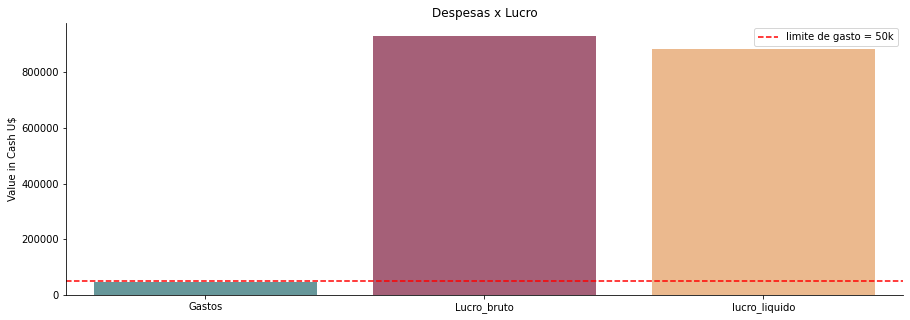

In [126]:
plt.figure(figsize=(15, 5))
sns.barplot(x=['Gastos', 'Lucro_bruto', 'lucro_liquido'],
            y=[metrics_business['discount_customer'].sum(),
               metrics_business['lucro_bruto'].sum(),
               metrics_business['lucro_liquido'].sum()], palette=[palette[0], palette[4], palette[2]])
sns.despine(right=True)
plt.ylabel('Value in Cash U$')
plt.title('Despesas x Lucro')
plt.axhline(50000, color='r', linestyle='dashed', label='limite de gasto = 50k')
plt.legend();

pd.DataFrame({'Lucro Total': np.round(metrics_business['lucro_liquido'].sum(), 2), 'Gasto cupom': np.round(metrics_business['discount_customer'].sum(), 3)}, index=[0])

# 10.0 DEPLOY

## 10.1 Salvar Modelo

In [259]:
pickle.dump(model_final_trained, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/model/model.pkl', 'wb'))

## 10.2 Salvar Transformações

In [255]:
# Min Max Scaler
pickle.dump(mms_balance_test, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/preparation/mms_balance.pkl', 'wb'))
pickle.dump(mms_salary_test, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/preparation/mms_salary.pkl', 'wb'))

# Robust Scaler
pickle.dump(rs_age_test, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/preparation/rs_age.pkl', 'wb'))
pickle.dump(rs_customer_return_test, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/preparation/rs_customer_return.pkl', 'wb'))

# Standard Scaler
pickle.dump(sc_credit_score_test, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/preparation/sc_credit_score.pkl', 'wb'))

## 10.3 50 Clientes que Receberão o Desconto

In [177]:
# data to json
data = json.dumps(send_api.to_dict(orient='records'))

#url = 'http://127.0.0.1:5000/CustomerChurn/predict'
url = 'https://api-churn.herokuapp.com/CustomerChurn/predict' # url heroku cloud
header = {'content-type': 'application/json'} # set type as json

# request with method POST
response = requests.post(url, data=data, headers=header)
print('Status code: {}'.format(response.status_code))

# json to dataframe
d1 = pd.DataFrame(response.json(), columns=response.json()[0].keys()).sort_values(by='churn_prediction', ascending=False).reset_index()
d1.iloc[:50, :][['customer_id', 'geography', 'churn_prediction']]

Status code: 200


,customer_id,geography,churn_prediction
0,15651983,France,0.772158
1,15616213,Germany,0.772158
2,15660524,Germany,0.772083
3,15578799,France,0.772083
4,15651103,Spain,0.770631
5,15653050,Germany,0.770563
6,15683213,France,0.743490
7,15650432,Germany,0.741372
8,15616550,Germany,0.727859
9,15599403,France,0.707389
